In [78]:
# deepsurv.py

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines.utils import concordance_index
from torch.utils.data import DataLoader, TensorDataset

# DeepSurv Neural Network
class DeepSurv(nn.Module):
    def __init__(self, input_dim):
        super(DeepSurv, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

# Negative partial log-likelihood loss
class CoxPHLoss(nn.Module):
    def forward(self, risk, time, event):
        order = torch.argsort(time, descending=True)
        risk = risk[order]
        event = event[order]

        log_cumsum_exp = torch.logcumsumexp(risk, dim=0)
        diff = risk - log_cumsum_exp
        loss = -torch.sum(diff * event) / event.sum()
        return loss

def train_deepsurv(df_train, feature_cols, time_col, event_col, epochs=500, lr=5e-5):
    scaler = StandardScaler()
    df_train[feature_cols] = scaler.fit_transform(df_train[feature_cols])

    x_train = torch.tensor(df_train[feature_cols].values, dtype=torch.float32)
    time_train = torch.tensor(df_train[time_col].values, dtype=torch.float32)
    event_train = torch.tensor(df_train[event_col].values, dtype=torch.float32)

    dataset = TensorDataset(x_train, time_train, event_train)
    loader = DataLoader(dataset, batch_size=256, shuffle=True)

    model = DeepSurv(input_dim=x_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    loss_fn = CoxPHLoss()

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for xb, tb, eb in loader:
            optimizer.zero_grad()
            risk_pred = model(xb).squeeze()
            loss = loss_fn(risk_pred, tb, eb)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        if epoch % 10 == 0:
            print(f"Epoch {epoch} | Loss: {epoch_loss:.4f}")

    return model, scaler

def evaluate_model(model, scaler, df_test, feature_cols, time_col, event_col):
    df_test[feature_cols] = scaler.transform(df_test[feature_cols])
    model.eval()
    x_test = torch.tensor(df_test[feature_cols].values, dtype=torch.float32)
    with torch.no_grad():
        log_risk = model(x_test).squeeze().numpy()
    df_test["log_risk"] = log_risk
    df_test["relative_risk"] = np.exp(log_risk)
    c_index = concordance_index(df_test[time_col], -log_risk, df_test[event_col])
    print("Concordance Index on test set:", round(c_index, 4))
    return df_test



In [79]:
df_full = pd.read_csv("C:\\Users\\Dell\\Desktop\\deepsa\\data\\final_data.csv")


In [80]:
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import matplotlib.pyplot as plt


In [81]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df_full, test_size=0.2, random_state=42)
feature_cols = ["age", "sex", "aps", "sps", "num.co", "wblc", "income"]

model, scaler = train_deepsurv(df_train, feature_cols, "time_active", "dropout")
df_test = evaluate_model(model, scaler, df_test, feature_cols, "time_active", "dropout")


Epoch 0 | Loss: 16.4200
Epoch 10 | Loss: 16.3668
Epoch 20 | Loss: 16.2907
Epoch 30 | Loss: 16.3866
Epoch 40 | Loss: 16.2085
Epoch 50 | Loss: 16.1151
Epoch 60 | Loss: 16.0472
Epoch 70 | Loss: 16.0613
Epoch 80 | Loss: 15.9164
Epoch 90 | Loss: 15.9355
Epoch 100 | Loss: 15.8007
Epoch 110 | Loss: 15.7235
Epoch 120 | Loss: 15.6861
Epoch 130 | Loss: 15.6395
Epoch 140 | Loss: 15.5852
Epoch 150 | Loss: 15.5271
Epoch 160 | Loss: 15.4553
Epoch 170 | Loss: 15.4723
Epoch 180 | Loss: 15.4531
Epoch 190 | Loss: 15.3694
Epoch 200 | Loss: 15.4231
Epoch 210 | Loss: 15.1842
Epoch 220 | Loss: 15.4394
Epoch 230 | Loss: 15.2900
Epoch 240 | Loss: 15.1768
Epoch 250 | Loss: 15.3536
Epoch 260 | Loss: 15.2553
Epoch 270 | Loss: 15.1082
Epoch 280 | Loss: 15.2891
Epoch 290 | Loss: 15.0912
Epoch 300 | Loss: 15.1790
Epoch 310 | Loss: 15.1740
Epoch 320 | Loss: 15.2128
Epoch 330 | Loss: 15.0942
Epoch 340 | Loss: 14.8531
Epoch 350 | Loss: 14.8842
Epoch 360 | Loss: 15.0521
Epoch 370 | Loss: 15.1012
Epoch 380 | Loss: 14.96

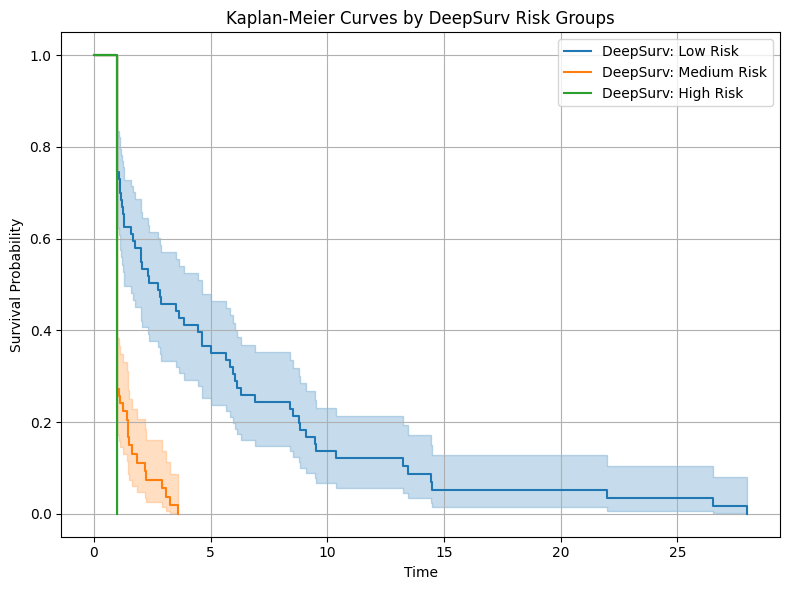

In [82]:

df_test["deepsurv_risk_group"] = pd.qcut(df_test["log_risk"], q=3, labels=["Low", "Medium", "High"])
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))

for group in ["Low", "Medium", "High"]:
    mask = df_test["deepsurv_risk_group"] == group
    kmf.fit(durations=df_test.loc[mask, "time_active"],
            event_observed=df_test.loc[mask, "dropout"],
            label=f"DeepSurv: {group} Risk")
    kmf.plot_survival_function()

plt.title("Kaplan-Meier Curves by DeepSurv Risk Groups")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()





In [84]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

print("📊 Median Survival Time by Risk Group:\n")

for group in ["Low", "Medium", "High"]:
    mask = df_test["deepsurv_risk_group"] == group
    kmf.fit(durations=df_test.loc[mask, "time_active"],
            event_observed=df_test.loc[mask, "dropout"],
            label=f"DeepSurv: {group} Risk")

    median_surv = kmf.median_survival_time_

    print(f" {group} Risk Group → Median survival time = {median_surv:.1f} days")


📊 Median Survival Time by Risk Group:

 Low Risk Group → Median survival time = 2.7 days
 Medium Risk Group → Median survival time = 1.0 days
 High Risk Group → Median survival time = 1.0 days
